# Softmax classifier gradient derivation

by [yrevar](https://github.com/yrevar) 

I have been taking [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) since past few weeks. I had to spend some time deriving gradients of the weights for [Softmax classifier](http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression) and [Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine). So, I am sharing my insights here, I hope you find it useful. I am trying to expand upon Softamx gradient here; kindly refer to [cs231n lecture notes](http://cs231n.github.io/linear-classify/) to learn in depth about linear classifiers. 

Note: If you are seeing this on GitHub and equations below doesn't render properly, kindly view this blog using [nbviewer](http://nbviewer.jupyter.org/github/yrevar/machine_learning/blob/master/softmax_gradient_derivation/softmax_gradient_derivation.ipynb)

## Linear Classifier

Let's talk about a simple linear classifier, in which class scores $z$ are calculated as:

```python
z = X.dot(W)
```

<img src="http://cs231n.github.io/assets/imagemap.jpg"></img>


(_picture courtesy: [cs231n](http://cs231n.stanford.edu/)_)

This is analogous to a single layer neural network. In the Softmax classifier, the score function mapping ${f(x_i;W)=Wx_i}$ stays same. But, on top of that we apply Sofmax function to these scores, and then we use cross-entropy loss to measure the error to update the gradients. Let's dive deeper into this.

## Sofmax function

[Sofmax function](https://en.wikipedia.org/wiki/Softmax_function) $p(z)$ takes a vector of arbitrary real-valued scores (e.g. predicted scores $z[]$) and squashes it to a vector of values between zero and one. In this particular exercise, you can interpret these scores as predicted class probabilities. 

$$ p(z) = \frac{e^{z}}{\sum_k {e^{z_k}}} $$

So, probability of the $j$-th class would be: 
$$ p_j(z) = \frac{e^{z_j}}{\sum_k {e^{z_k}}} $$

In pythonic way, a naive version of the softmax function can be written as:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z), axis=0)

In [6]:
z = np.arange(-3.0, 5.0, 1.0)
print "scores: ", z
p = softmax(z)
print "probabilities: ", p

scores:  [-3. -2. -1.  0.  1.  2.  3.  4.]
probabilities:  [  5.76612770e-04   1.56739601e-03   4.26062410e-03   1.15815771e-02
   3.14819905e-02   8.55769227e-02   2.32622194e-01   6.32332683e-01]


Let's try to visualize this with more data:

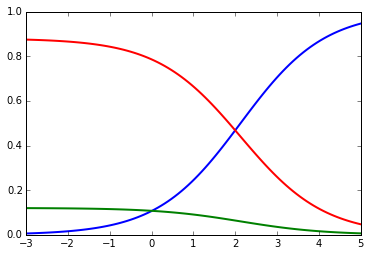

In [8]:
# Let's assume there are 100 classes for which we get arbitrary score values
z = np.linspace(-3.0, 5.0, 100)
# Create 2 more arrays and stack them together to see what softmax does to them
scores = np.vstack([z, 0.01*np.ones_like(z), 2.0*np.ones_like(z)])
plt.plot(z, softmax(scores).T, linewidth=2)
plt.show()

As we can see, probability values change as we change our scores, but they always sum to one. It's interesting to note that as the separation between different score values increases we get steeper curve. To undertand better, let's take a small example. 

In [10]:
z=np.array([1,2])
softmax(z)

array([ 0.26894142,  0.73105858])

In [11]:
z=np.array([1,100])
softmax(z)

array([  1.01122149e-43,   1.00000000e+00])

Isn't it natural? 100 is way far away from 1 than 2 is so it was assigned class score of nearly 1.0. We could relate this to [Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine), but Softmax takes into account all of the class scores regardless of their separation with the correct class while SVM stops caring after when a desired level of separation is achieved.

In practice, we want the scores $z$ to be bounded to certain range for the numerical stability, i.e., overflow and underflow associated with softmax function.

## Cross Entropy Loss

We want these estimated class probabilities in such a way that we get the class score of 1.0 (ideally) for correct class and 0.0 for others. Unless we are really lucky with the weights, which is highly unlikely, our randomly initialized weights won't lead us to the correct scores in one shot. And, we'll always see [residual errors](https://en.wikipedia.org/wiki/Errors_and_residuals) in the predicted scores. To quantify the errors, we define loss function. Let's step back and reiterate our final objective which is to classify correctly, and for that we need to come up with model parameters $(W,b)$ that minimize this loss value; therefore, we need to select loss function which makes this job easier for us. I won't go into much detail about optimization (to find out more about how to go from errors to optimizing weights you can read more about optimization techniques [here](http://cs231n.github.io/optimization-1/) or [here](https://www.cs.berkeley.edu/~jordan/courses/294-fall09/lectures/optimization/slides.pdf)). The simplest loss function is [Sum of Squared Errors(SSE)](https://en.wikipedia.org/wiki/Residual_sum_of_squares), which is an ideal candidate for a real-valued data (e.g. in [linear regression](https://en.wikipedia.org/wiki/Linear_regression)), but in classification, we need a loss function that can do a great job in separating 0 and 1. In other words, when predicted class score is 0 instead of true score 1, the loss function should produce a high loss and vice versa. We can see that, negative of the $log()$ function does that job pretty nicely. 

(0, 10)

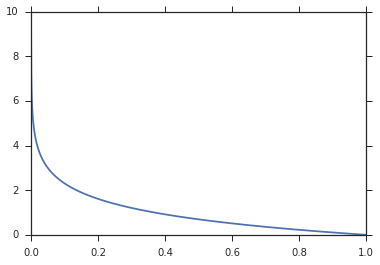

In [150]:
plt.plot(np.arange(0,10,0.0001), -np.log(np.arange(0,10,0.0001)))
plt.xlim(0,1)
plt.ylim(0,10)

In [151]:
-np.log(0)

inf

For simplicity, let's consider $Y$ as one-hot encoded labels for correct label $y$ ([one hot encoding](http://stackoverflow.com/questions/17469835/one-hot-encoding-for-machine-learning)). $Y_i$ is one-hot encoded vector for i-th training label, and $Y_i,_j$ is $j$-th class score for $i$-th training label (which is 0 for all j except when $j == y_i$).   

The [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) between a "true" distribution $p$ and an estimated distribution $q$ is defined as:

$$ H(p,q) = -\sum_x p(x) log( q(x) ) $$

We are minimizing negative log likelihood of the correct class score. Intuitively, we are penalizing all correct class scores which are less than 1.0, and our penalty increases exponentially as we move towards 0 and reaches to $-\infty$. The Softmax classifier is hence minimizing the cross-entropy between the estimated class probabilities $p(z)$ and the "true" distribution $Y_i$, which in this interpretation is the distribution where all probability mass is on the correct class (i.e. p=[0,…1,…,0]p=[0,…1,…,0] contains a single 1 at the $yi$-th position). 

$$ L_i = -\sum_j Y_i,_j log( \frac { e^{f_{j}} } { \sum_k {e^{f_k}} } )$$ 

For $i$-th example, $Y_i,_j$ is zero except at position $y_i$, which is true class label for $i$-th training input. So, our loss equation simplifies to: 

$$L_i = -log( \frac { e^{f_{y_i}} } { \sum_k {e^{f_k}} } )$$ 

That means we are only collecting loss for correct label scores. The further the score moves away from 1.0, the higher the loss we accumulate (in -log fashion, which goes to $\infty$ at 0.0). In practice, we initialized weights in such a manner that class scores are bounded to certain range, in order to avoid numeric stability issues associated with softmax and log function. 

Simplifying further...

$$L_i = -f_{y_i} + log(\sum_k {e^{f_k}})$$

$$L_i = -w_{y_i}x_i + log(\sum_k {e^{w_k x_i}})$$ 

## Gradient of the loss function

$$\begin{equation}\frac{\partial L_i}{\partial w_j} = -\frac{\partial w_{y_i}} {\partial w_j} x_i + \frac {1} {\sum_k {e^{w_k x_i}}} \cdot \frac{\partial}{\partial w_j} (\sum_k e^{w_k x_i})\end{equation}$$ 

Applying derivative chain rule leads to:

$$\begin{equation}\frac{\partial}{\partial w_j} (\sum_k e^{w_k x_i}) = \frac{\partial}{\partial w_k x_i} (\sum_k e^{w_k x_i}) \cdot \frac{\partial w_k xi}{\partial w_j}\end{equation}$$

We know that $\frac{\partial e^{x}}{\partial x} = e^x$; however

$$\begin{equation}\frac{\partial w_k xi}{\partial w_j} = \left\{ \begin{array}{ll} 0 & \mbox{if } k \neq j \\ x_i & \mbox{if } k = j \end{array} \right.\end{equation}$$

Combining eq. (1), (2) & (3) we get:

$$\frac{\partial L_i}{\partial w_j} = -\frac{\partial w_{y_i}} {\partial w_j} x_i + \frac {e^{w_j x_i}} {\sum_k {e^{w_k x_i}}} x_i$$ 

The term $\frac {e^{w_j x_i}} {\sum_k {e^{w_k x_i}}}$ is the softmax score for the class j which we already computed i.e. $p_j(z)$. In other words:

$$\frac{\partial L_i}{\partial w_j} = -\frac{\partial w_{y_i}} {\partial w_j} x_i + p_j(z) x_i$$

$$\frac{\partial L_i}{\partial w_j} = (p_j(z) - \frac{\partial w_{y_i}} {\partial w_j})x_i$$

$\frac{\partial w_{y_i}} {\partial w_j} = \left\{ \begin{array}{ll} 0 & \mbox{if } j \neq y_i \\ 1 & \mbox{if } j = y_i \end{array} \right.$

In code, gradient update would simply be:
```python 
dW[:,j] += (p[j] - (j==y[i]))*X[i,:] 
```

*This post was written in a Jupyter Notebook. If you'd like to run the code yourself, download the notebook [here](https://github.com/yrevar/machine_learning/blob/master/softmax_gradient_derivation/softmax_gradient_derivation.ipynb).*